### Libraries 

In [5]:
import tensorflow as tf
if int(tf.__version__[0]) < 2:
    tf.enable_eager_execution()

In [265]:
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import relu, tanh, elu
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.client import device_lib

import warnings
import numpy as np
import csv
import astetik as ast
from collections import Counter
from sklearn.metrics import hamming_loss

import json

import scipy
from scipy.io import loadmat
from scipy.sparse import csr_matrix
from collections import defaultdict
from itertools import combinations

from os import listdir
from os.path import isfile, join
from ast import literal_eval as le

import talos as ta
from talos.model.early_stopper import early_stopper
from talos.metrics.keras_metrics import precision as precision_acc

import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

The initial form of the dataset is label1,label2,...labelk ft1:ft1_val ft2:ft2_val ft3:ft3_val .. ftd:ftd_val. 
So in order to read it we compile with mex compiler a make file that provides us some C++ files, read/write functions for that form.
With the command  [ft_mat, lbl_mat] = read_data("data.txt"); we read the feautures and lebel arrays in sparse form and with the command
csvwrite("features.csv", full(ft_mat)) we write the arrays in csv form in order to read it easily in python.

We have been also provided with a train and a test file for each dataset which contain sets of indices to the feature file.

### Load Data

In [8]:
def augment_labels(Y):
    L, N = Y.shape
    mis = np.argwhere(Y.sum(axis=0) == 0)
    Y_aug = np.zeros((L+1, N))
    if scipy.sparse.issparse(Y):
        Y = Y.todense()
    Y_aug[:-1, :] = Y
    Y_aug[-1, mis] = 1
    return Y_aug

In [9]:
def load_simple_dataset(dataset_name, path=''):
    all_data   = np.genfromtxt(path+'datasets/' + dataset_name + '_features_mat.csv', delimiter=',')
    all_labels = np.genfromtxt(path+'datasets/' + dataset_name + '_labels_mat.csv', delimiter=',')
    train_idx  = np.genfromtxt(path+'datasets/' + dataset_name + '_trSplit.csv', delimiter=' ')
    test_idx   = np.genfromtxt(path+'datasets/' + dataset_name +'_tstSplit.csv',delimiter=' ')

    splits_num = train_idx.shape[1]

    train_idx = train_idx.astype(int)
    test_idx = test_idx.astype(int)

    splits_num = train_idx.shape[1]
    
    examples_with_no_labels = all_labels.shape[1]-sum(all_labels.max(0))
    print(dataset_name, ": # of examples with no labels:", examples_with_no_labels)
    print(dataset_name, ": % of examples with no labels:", examples_with_no_labels / all_labels.shape[0])

    if examples_with_no_labels > 0:
        all_labels = augment_labels(all_labels)

    for i in range(splits_num):
        X_train = all_data[:, train_idx[:, i] - 1]
        X_test  = all_data[:, test_idx[:, i] - 1]

        X_train = X_train.T
        X_test = X_test.T

        Y_train = all_labels[:, train_idx[:, i] - 1]
        Y_train = Y_train.T

        Y_test = all_labels[:, test_idx[:, i] - 1]
        Y_test = Y_test.T

        yield X_train, Y_train, X_test, Y_test

In [10]:
def load_sparse_dataset(dataset_name, path=''):
    X_test  = loadmat(path+'datasets/' + dataset_name + '_features_test.mat')['features_test']
    X_train = loadmat(path+'datasets/' + dataset_name + '_features_train.mat')['features_train']
    Y_test  = loadmat(path+'datasets/' + dataset_name + '_labels_test.mat')['labels_test']
    Y_train = loadmat(path+'datasets/' + dataset_name + '_labels_train.mat')['labels_train']
    
    examples_with_no_labels = Y_train.shape[1]-np.sum(Y_train.max(0))
    print(dataset_name, ": # of train examples with no labels:", examples_with_no_labels)
    print(dataset_name, ": % of train examples with no labels:", examples_with_no_labels / Y_train.shape[0])

    if examples_with_no_labels > 0:
        Y_train = augment_labels(Y_train)
        
    examples_with_no_labels = Y_test.shape[1]-np.sum(Y_test.max(0))
    print(dataset_name, ": # of test examples with no labels:", examples_with_no_labels)
    print(dataset_name, ": % of test examples with no labels:", examples_with_no_labels / Y_test.shape[0])

    if examples_with_no_labels > 0:
        Y_test = augment_labels(Y_test)
    
    yield csr_matrix(X_train.T), csr_matrix(Y_train.T), csr_matrix(X_test.T), csr_matrix(Y_test.T) 

In [277]:
def load_dataset(dataset_name, colab=False):
    path = ''
    if colab:
        path = '/content/drive/My Drive/Colab Notebooks/mc/'
    if dataset_name == 'RCV' or dataset_name == 'eurlex':
        return load_sparse_dataset(dataset_name, path)
    else:
        return load_simple_dataset(dataset_name, path)

In [12]:
sp=load_dataset('eurlex')
for i in sp:
    pass

eurlex : # of train examples with no labels: 28.0
eurlex : % of train examples with no labels: 0.007012271475081392
eurlex : # of test examples with no labels: 6.0
eurlex : % of test examples with no labels: 0.0015026296018031556


### Cost function
  $$ E(w) = \sum_{i=1}^{n} \sum_{k=1}^{K} [ y_{i,k} log \sigma_{i,k} + (1 - y_{i,k})log(1 - \sigma_{i,k}) ]$$

Ι created a 3 layer Neural Network with Adam optimizer and with relu activation functions in hidden layers and sigmoid in the last one. Ι also added dropout and batch normalization in order to avoid overfitting. 

### Metrics

#### 1) Mean Average Precision @ k

$$\mathrm{P} @ k :=\frac{1}{k} \sum_{l \in \operatorname{rank}_{k}(\hat{\mathbf{y}})} \mathbf{y}_{l}$$

apk function computes the average prescision at k between two lists of
items. I created 4 apks. Strict is when I multiply weigths with (i + 1), soft is when I devide with min(len(Y_true_row), k), so in case k > labels, I devide with #labels. In the documentation of the datasets apk has been used.  

Parameters  

Y_true_row : list  
         A list of elements that are to be predicted (order doesn't matter) <br>
Y_pred_row : list  
         A list of predicted elements (order does matter)<br>
k : int, optional
    The maximum number of predicted elements
    
weights: list 
         Used for prospensity score 
Returns 

score  : double
        The average precision at k over the input lists

In [15]:
def strict_soft_apk(Y_true_row, Y_pred_row, k, weights):
    if len(Y_pred_row) > k:
        Y_pred_row = Y_pred_row[:k]

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(Y_pred_row):
        if p in Y_true_row: #and p not in Y_pred[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0) * weights[p]
            
    if len(Y_true_row) == 0:
        return 0.0
    
    return score / min(len(Y_true_row), k)

In [16]:
def soft_apk(Y_true_row, Y_pred_row, k, weights):
    if len(Y_pred_row) > k:
        Y_pred_row = Y_pred_row[:k]

    score = 0.0
    for i, p in enumerate(Y_pred_row):
        if p in Y_true_row: #and p not in Y_pred[:i]:
            score += 1 * weights[p]
            
    if len(Y_true_row) == 0:
        return 0.0
    
    return score / min(len(Y_true_row), k)

In [17]:
def strict_apk(Y_true_row, Y_pred_row, k, weights):
    if len(Y_pred_row) > k:
        Y_pred_row = Y_pred_row[:k]

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(Y_pred_row):
        if p in Y_true_row: #and p not in Y_pred[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0) * weights[p]
            
    if len(Y_true_row) == 0:
        return 0.0
    
    return score / k

In [18]:
def apk(Y_true_row, Y_pred_row, k, weights):
    if len(Y_pred_row) > k:
        Y_pred_row = Y_pred_row[:k]

    score = 0.0
    for i, p in enumerate(Y_pred_row):
        if p in Y_true_row: #and p not in Y_pred[:i]:
            score += 1 * weights[p]
            
    if len(Y_true_row) == 0:
        return 0.0
    
    return score / k

To count the accuracy of our model I used mapk function that computes the mean average precision at k between two lists
of lists of items.


In [19]:
def mapk(k, apk_func=apk):
    def _mapk(Y_true, Y_pred):
        if type(Y_pred) is not np.ndarray:
            Y_pred = Y_pred.numpy()
            Y_true = Y_true.numpy()
        uni_wts = np.ones(Y_true.shape[1])
        Y_true, Y_pred = get_labeled(Y_true, Y_pred)
        res = np.mean([apk_func(t,p, k, uni_wts) for t,p in zip(Y_true, Y_pred)])
        return res
    _mapk.__name__ = 'map' + '-[' + apk_func.__name__ + '] @' + str(k) 
    return _mapk

#### 2) Propenisty-weighted Mean Average Precision @ k

$$\operatorname{PSP} @ k :=\frac{1}{k} \sum_{l \in \operatorname{rank}_{k}(\hat{\mathbf{y}})} \frac{\mathbf{y}_{l}}{p_{l}}$$

In [20]:
def get_inv_propensity(Y_train, A=0.55, B=1.5):

# Returns inverse propensity weights
# A,B are parameters of the propensity model. Refer to paper for more details.
# A,B values used for different datasets in paper:
# Amazon: A=0.6,  B=2.6
# Other:  A=0.55, B=1.5

    num_inst = Y_train.shape[0]
    freqs = np.sum(Y_train, axis=0)
    C = (np.log(num_inst)-1) * (B+1)**A
    wts = 1 + C * np.power(freqs+B, -A)
    return np.array(wts).reshape(-1)

In [21]:
def mapk_propensity(k, wts, apk_func=apk):
    def _mapk_propensity(Y_true, Y_pred):
        def mapk_propensity_partial(Y_true_labeled, Y_pred):
            return np.mean([apk_func(t,p, k, wts) for t,p in zip(Y_true_labeled, Y_pred)])
        
        if type(Y_pred) is not np.ndarray:
            Y_pred = Y_pred.numpy()
            Y_true = Y_true.numpy()
        Y_true_labeled, Y_pred = get_labeled(Y_true, Y_pred)   

        wt_true = np.array(Y_true) @ np.array(np.diag(wts))
        wt_true_topk = []
        for row in wt_true:
            wt_true_topk.append(row.argsort()[-k:][::-1].tolist())

        num = mapk_propensity_partial(Y_true_labeled, Y_pred)
        den = mapk_propensity_partial(Y_true_labeled, wt_true_topk)

        return num/den
    _mapk_propensity.__name__ = 'map_prop@' + str(k)
    return _mapk_propensity

#### 3) nDCG @ k (simple and propensity weighted)

$$\mathrm{DCG} @ k :=\sum_{l \in \operatorname{rank}_{k}(\hat{\mathbf{y}})} \frac{\mathbf{y}_{l}}{\log (l+1)}$$

In [22]:
def DCG_k(Y_true_row, Y_pred_row, k, wts):
    if len(Y_pred_row) > k:
        Y_pred_row = Y_pred_row[:k]
        
    score = 0.0
    for i, p in enumerate(Y_pred_row):
        if p in Y_true_row: #and p not in Y_pred[:i]:
            score += 1 / np.log2(i+2.0)*wts[p]
            
    return score

In [23]:
def nDCG_k(Y_true_row, Y_pred_row, k, wts):
    return DCG_k(Y_true_row, Y_pred_row, k,  wts) / DCG_k(Y_true_row, list(Y_true_row), k, wts)

In [24]:
def mean_nDCG_k(k, weights=None):   
    def _mean_nDCG_k(Y_true, Y_pred):
        if type(Y_pred) is not np.ndarray:
            Y_pred = Y_pred.numpy()
            Y_true = Y_true.numpy()
        weighted = True
        wts = weights
        if weights is None:
            wts = np.ones(Y_true.shape[1])
            weighted = False
            
        Y_true, Y_pred = get_labeled(Y_true, Y_pred) 
        return np.mean([nDCG_k(t, p, k, wts) for t,p in zip(Y_true, Y_pred)])
    weight_str = ''
    if not weights:
        weight_str = '_prop'
    _mean_nDCG_k.__name__ = 'nDCG' + weight_str + '@' + str(k)    
    return _mean_nDCG_k

#### 4) Recall @ k

In [25]:
def recall_k(Y_true_row, Y_pred_row, k):
    if len(Y_pred_row) > k:
        Y_pred_row = Y_pred_row[:k]

    score = 0.0
    for i, p in enumerate(Y_pred_row):
        if p in Y_true_row: #and p not in Y_pred[:i]:
            score += 1 

    if len(Y_true_row) == 0:
        return 0.0

    return score / len(Y_true_row)

In [26]:
def mean_recall_k(k):
    def _mean_recall_k(Y_true, Y_pred):
        if type(Y_pred) is not np.ndarray:
                Y_pred = Y_pred.numpy()
                Y_true = Y_true.numpy()
        Y_true, Y_pred = get_labeled(Y_true, Y_pred)   
        return np.mean([recall_k(t,p, k) for t,p in zip(Y_true, Y_pred)])
    
    _mean_recall_k.__name__ = 'recall@' + str(k)
    return _mean_recall_k

#### 5) Coverage @ k

In [6]:
def get_masked_array(A, k):
    N = A.shape[0]
    A_= (-A).argsort(axis=1)
    A_k = A_[:, :k]
    ax0 = np.tile(np.arange(N), (k,1)).T
    idx = [ax0, A_k]
    
    mask = np.zeros_like(A, dtype=np.bool_)
    mask[idx] = 1
    A[mask] = 1
    A[~mask] = 0
    
    return A

In [2]:
def coverage_propensity(k, weights):
    
    def _coverage_propensity(Y_true, Y_pred):
        if type(Y_pred) is not np.ndarray:
                Y_pred = Y_pred.numpy()
                Y_true = Y_true.numpy()
        weighted = True
        wts = weights
        if weights is None:
            wts = np.ones(Y_true.shape[1])
            weighted = False

        Y_pred = get_masked_array(Y_pred, k)
        score_mat = (Y_pred @ np.diag(wts)) * Y_true
        
        wt_true = np.array(Y_true) @ np.array(np.diag(wts))
        wt_true = get_masked_array(wt_true, k)

        true_score_mat = (wt_true @ np.diag(wts)) * Y_true
        return score_mat.sum() / true_score_mat.sum()
    weight_str = ''
    if not weights:
        weight_str = '_prop'
    _coverage_propensity.__name__ = 'coverage' + weight_str + '@' + str(k)  
    return _coverage_propensity

#### 6) f1score

In [29]:
def f1score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

### Model

In [14]:
def get_labeled(Y_true, Y_pred, max_k=5):
    # get top-k prediction labels
    Y_pred_topk = []
    for row in Y_pred:
        Y_pred_topk.append(row.argsort()[-max_k:][::-1].tolist())

    # get Y_true labels
    Y_true_labels = []
    for row in Y_true:
        Y_true_labels.append(set(np.nonzero(row)[0].tolist()))  
        
    return Y_true_labels, Y_pred_topk

In [30]:
def save_history(histories, dataset_name):
    for i, history in enumerate(histories):
        with open("histories/" + dataset_name + "/split" + str(i) + '.json', 'w') as outfile:
            if isinstance(history, dict):
                json.dump(str(history), outfile)
            else:
                json.dump(str(history.history), outfile)

In [31]:
def load_history(dataset='bibtex'):
    path = 'histories' + '/' + dataset
    histories = []
    splits = sorted([f for f in listdir(path) if isfile(join(path, f))])
    for split in splits:
        with open(path + '/' + split) as f:
            history = le(json.load(f))
            histories.append(history)
    return histories

In [27]:
def get_model(input_dim, optimizer='Adam', layers_dim=None, activations=None, dropouts=None, batch_norm=None):
    
    if layers_dim is None:
        layers_dim = [100, 50, 20]
    if activations is None:
        activations = ['relu', 'relu', 'relu']
    if dropouts is None:
        dropouts = [0.25, 0.25, 0.25]
    if batch_norm is None:
        batch_norm = [True, True, True]
    if not (len(layers_dim) == len(activations) == len(dropouts) == len(batch_norm)):
        print("layers_dim, activations, dropouts and batch_norm must have the exact same size - the number of hidden layers")
        return None
   
    inputs_dim = [input_dim] + layers_dim
    
    model = Sequential()
   
    for hidden_layer_num in range(len(layers_dim)):        
        
        bn = batch_norm[hidden_layer_num]       
        if bn is not None and bn is True:
            if hidden_layer_num == 0:
                model.add(BatchNormalization(input_shape=(input_dim,)))
            else:
                model.add(BatchNormalization())
        
        layer_dim = layers_dim[hidden_layer_num]
        input_dim = inputs_dim[hidden_layer_num]
        activation = activations[hidden_layer_num]    
        
        
        model.add(Dense(layer_dim, input_dim=input_dim, activation=activation, use_bias=False))
        
        dropout = dropouts[hidden_layer_num]
        if dropout is not None and dropout != 0: 
            model.add(Dropout(0.25))
    return model


In [28]:
def batch_generator(X, y, batch_size, shuffle):
    is_sparse = False
    if scipy.sparse.issparse(X):
        is_sparse = True
        
    number_of_batches = X.shape[0]//batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:]
        y_batch = y[batch_index]
        if is_sparse:
            X_batch = X_batch.toarray()
            y_batch = y_batch.toarray()
            
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [ ]:
ks = [1, 3, 5]
histories = []
batch_size = 32
epochs = 100
#'bibtex', 
datasets = ['eurlex', 'delicious', 'Mediamill', 'Eurlex', 'RCV-x']
#######
GPU_list = get_available_gpus()
device = None
if len(GPU_list) > 0:
    device = GPU_list[0]
else:
    device = get_available_cpus()[0]
#######
with tf.device(device):
    print('USING', device)
    for d in datasets:
        for i, split in enumerate(load_dataset(d)):
            X_train, Y_train, X_test, Y_test = split
            print('Training on', d, '...')
            print('Split:', (i+1))
             # Propensity weights
            weights = get_inv_propensity(Y_train, A=0.55, B=1.5).tolist()
            metrics_funcs = []
            for k in ks:
                metrics_funcs.extend([mapk(k, apk), mapk(k, soft_apk), mapk(k, strict_apk), mapk(k, strict_soft_apk), 
                                      mapk_propensity(k, weights),
                                      mean_nDCG_k(k, None), mean_nDCG_k(k, weights),
                                      mean_recall_k(k), 
                                      coverage_propensity(k, None), coverage_propensity(k, weights)])

            model = get_model(X_train.shape[1], optimizer='Adam', layers_dim=[1000, 1200, Y_train.shape[1]],\
                              activations=['relu', 'relu', 'sigmoid'], dropouts=[0.5, 0.5, 0],\
                              batch_norm=[True, True, False])
            model.compile(optimizer='Adam', loss='binary_crossentropy', run_eagerly=True, 
                          metrics=metrics_funcs)

            callbacks = [EarlyStopping(monitor='val_loss', verbose=1, patience=7), 
                         ModelCheckpoint(filepath='best_model_'+datasets[0]+ "_split:" + str(i) +'.h5', monitor='val_loss', save_best_only=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)]

            history = model.fit_generator(generator=batch_generator(X_train, Y_train , batch_size, True), 
                                          epochs=epochs, steps_per_epoch=X_train.shape[0]//batch_size, 
                                          validation_data=batch_generator(X_test, Y_test , batch_size, True),
                                          validation_steps=X_test.shape[0]//batch_size, callbacks=callbacks,
                                          use_multiprocessing=False,
                                          verbose=0) 

            histories.append(history)
        save_history(histories, d)

USING /device:XLA_GPU:0
eurlex : # of train examples with no labels: 28.0
eurlex : % of train examples with no labels: 0.007012271475081392
eurlex : # of test examples with no labels: 6.0
eurlex : % of test examples with no labels: 0.0015026296018031556
Training on eurlex ...
Split: 1


## Exploratory Analysis of the Labels distribution

In [285]:
def get_pred(dataset):
    for split in load_dataset(dataset):
        X_train, Y_train, X_test, Y_test = split
        break;
    
    model = load_model('best_model/'+dataset+'/best_model_'+dataset+'_split_0.h5', compile=False)
    Y_pred_test = model.predict_proba(X_test)
    Y_pred_test[Y_pred_test >= 0.5] = 1
    Y_pred_test[Y_pred_test < 0.5] = 0
    
    Y_pred_train = model.predict_proba(X_train)
    Y_pred_train[Y_pred_train >= 0.5] = 1
    Y_pred_train[Y_pred_train< 0.5] = 0
    
    return Y_pred_test, Y_pred_train, Y_test, Y_train

In [350]:
def get_label_distribution(dataset, Y_pred, Y_test, str_):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    fig.suptitle(str_, fontsize=20)
    toplot_test = np.array(np.sum(Y_test, axis=0)).ravel()
    ax[0].hist(toplot_test, bins=50)
    #ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Label Distribution: Y_true', fontsize=15)
    ax[0].set_xlabel('labels', fontsize=15)
    ax[0].set_ylabel('data', fontsize=15)
    #ax[0].set_ylim(0, 800)
    
    toplot_pred = np.array(np.sum(Y_pred, axis=0)).ravel()
    ax[1].hist(toplot_pred, bins=50)
    #ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title('Label Distribution: Y_pred', fontsize=15)
    ax[1].set_xlabel('labels', fontsize=15)
    ax[1].set_ylabel('data', fontsize=15)
    
    data_sum = toplot_pred.astype(int)
    data_sum_pr = toplot_test.astype(int)
    
    print('~~~~~~~~~~~~~~~~~~~~~~', str_, '~~~~~~~~~~~~~~~~~~~~~~')
    print("True Mean data per label  |", np.mean(data_sum),
          "\nPredicted                 |", np.mean(data_sum_pr),
          "\nTrue Std  data per label  |", np.std(data_sum),
          "\nPredicted                 |", np.std(data_sum_pr))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

In [351]:
def get_labels_per_datum(dataset, Y_pred, Y_test, str_):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    fig.suptitle(str_, fontsize=20)
    toplot_test = np.array(Y_test.sum(axis=1)).ravel()
    ax[0].hist(toplot_test, bins=30)
    #ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Labels/Data Distribution: Y_true', fontsize=15)
    ax[0].set_xlabel("data", fontsize=15)
    ax[0].set_ylabel("label", fontsize=15)
    #ax[0].set_xlim(0, 30)
    
    toplot_pred = np.array(Y_pred.sum(axis=1)).ravel()
    ax[1].hist(toplot_pred, bins=30)
    #ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title('Labels/Data Distribution: Y_pred', fontsize=15)
    ax[1].set_xlabel("data", fontsize=15)
    ax[1].set_ylabel("label", fontsize=15)
    #ax[1].set_xlim(0, 16)
    
    labels_sum = toplot_test.astype(int)
    labels_sum_pr = toplot_pred.astype(int)
    print('~~~~~~~~~~~~~~~~~~~~~~', str_, '~~~~~~~~~~~~~~~~~~~~~~')
    print("True Mean labels per data |", np.mean(labels_sum), 
          "\nPredicted                 |", np.mean(labels_sum_pr),
          "\nTrue Std  labels per data |", np.std(labels_sum),
          "\nPredicted                 |", np.std(labels_sum_pr))

### Bibtex

bibtex : # of examples with no labels: 0.0
bibtex : % of examples with no labels: 0.0


W0724 16:53:04.387496 140095610189632 deprecation.py:506] From /u/37/papathd1/unix/anaconda3/envs/eva/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 16:53:04.389576 140095610189632 deprecation.py:506] From /u/37/papathd1/unix/anaconda3/envs/eva/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 16:53:04.459382 140095610189632 deprecation.py:506] From /u/37/papathd1/unix/anaconda3/envs/eva/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling

~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 38.22641509433962 
Predicted                 | 3.4716981132075473 
True Std  data per label  | 35.554179495542876 
Predicted                 | 30.512769019167056
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 2.416699801192843 
Predicted                 | 0.2194831013916501 
True Std  labels per data | 1.6961303881419285 
Predicted                 | 0.42433216294041337
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 73.48427672955975 
Predicted                 | 6.849056603773585 
True Std  data per label  | 66.4259038039754 
Predicted                 | 58.49766846713753
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 2.394262295081967 
Predicted                 | 0.22315573770491803 
True Std  labels per data

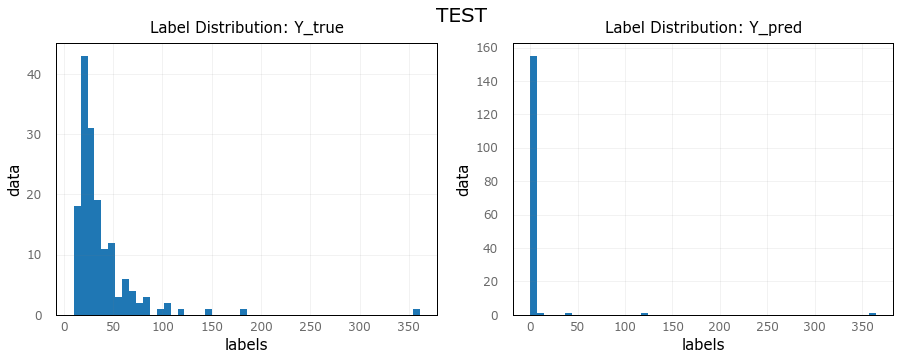

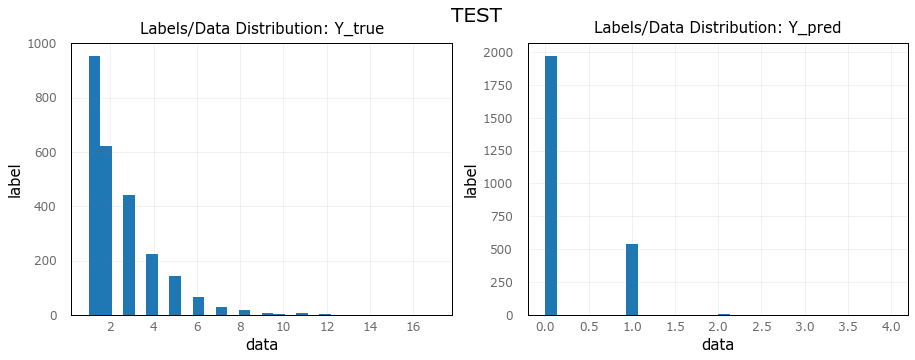

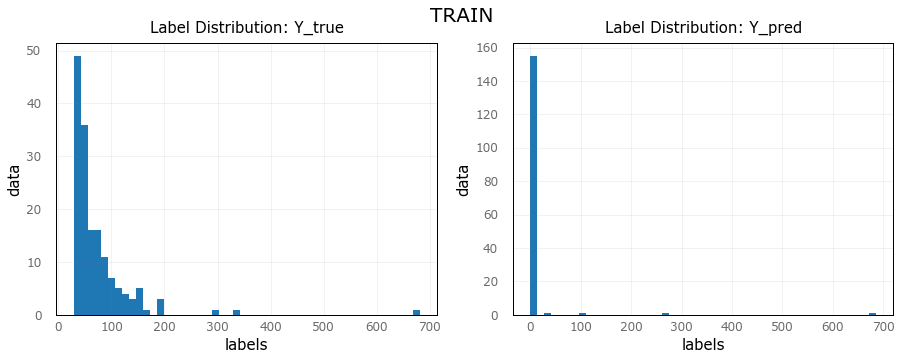

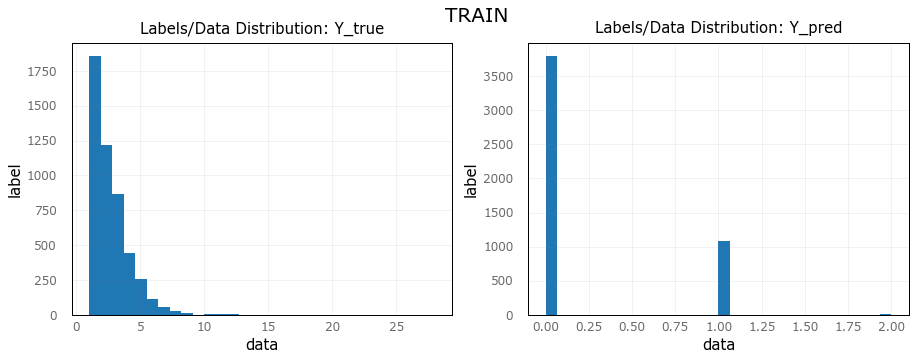

In [272]:
Y_pred_test, Y_pred_train, Y_test, Y_train = get_pred('bibtex')
get_label_distribution('bibtex',  Y_pred_test, Y_test, 'TEST')
get_labels_per_datum('bibtex', Y_pred_test, Y_test, 'TEST')


get_label_distribution('bibtex',  Y_pred_train, Y_train, 'TRAIN')
get_labels_per_datum('bibtex', Y_pred_train, Y_train, 'TRAIN')

### Mediamill

mediamill : # of examples with no labels: 1730.0
mediamill : % of examples with no labels: 17.128712871287128
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 556.1764705882352 
Predicted                 | 349.79411764705884 
True Std  data per label  | 1435.5289276749056 
Predicted                 | 1423.6236858063749
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 4.392906922719529 
Predicted                 | 2.762815549016571 
True Std  labels per data | 2.25589912534297 
Predicted                 | 1.4835451814149447
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 1344.2941176470588 
Predicted                 | 858.1274509803922 
True Std  data per label  | 3452.6430642597684 
Predicted                 | 3407.113089024681
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean la

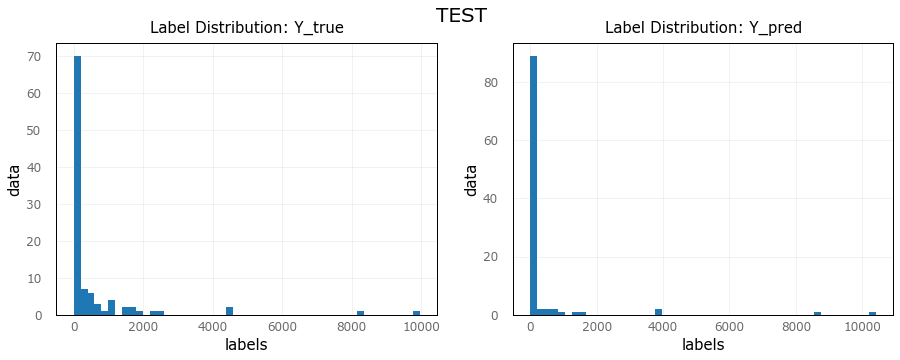

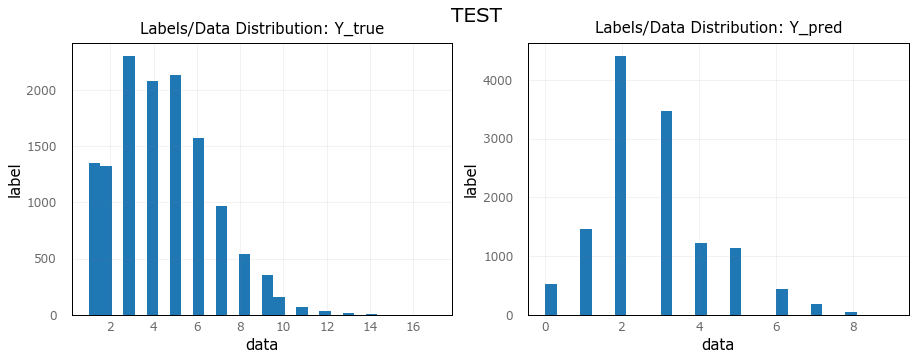

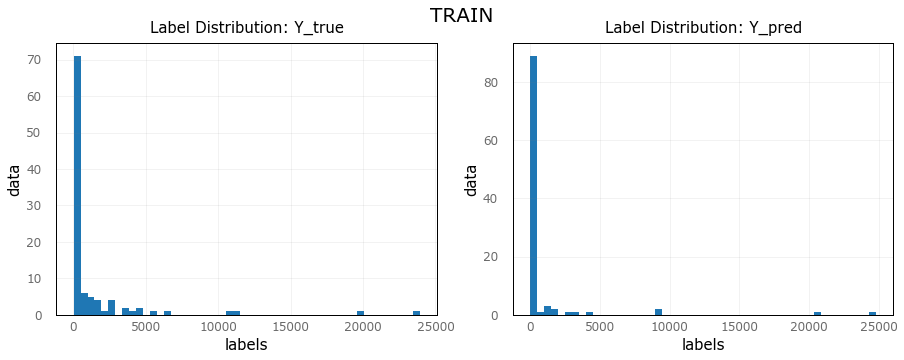

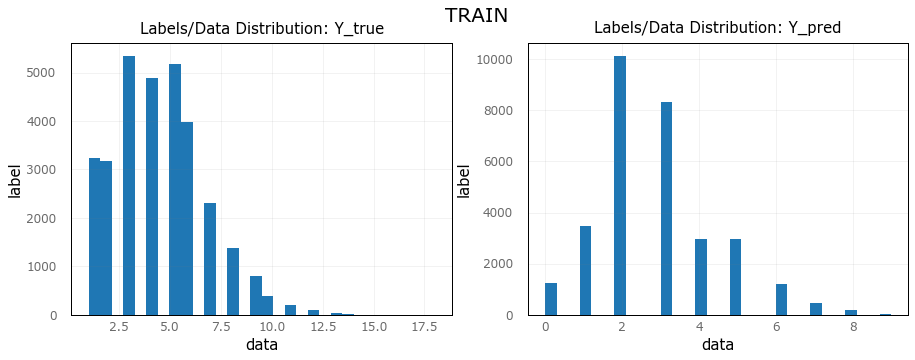

In [274]:
Y_pred_test, Y_pred_train, Y_test, Y_train = get_pred('mediamill')
get_label_distribution('mediamill',  Y_pred_test, Y_test, 'TEST')
get_labels_per_datum('mediamill', Y_pred_test, Y_test, 'TEST')


get_label_distribution('mediamill',  Y_pred_train, Y_train, 'TRAIN')
get_labels_per_datum('mediamill', Y_pred_train, Y_train, 'TRAIN')

### Delicious

delicious : # of examples with no labels: 14.0
delicious : % of examples with no labels: 0.014242115971515769
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 61.36280487804878 
Predicted                 | 22.996951219512194 
True Std  data per label  | 124.38343662875623 
Predicted                 | 85.9478890075334
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 18.957927786499216 
Predicted                 | 7.104866562009419 
True Std  labels per data | 5.069202802809304 
Predicted                 | 5.48819124963365
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 249.9491869918699 
Predicted                 | 107.6900406504065 
True Std  data per label  | 514.8730953629324 
Predicted                 | 365.8132499011625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels

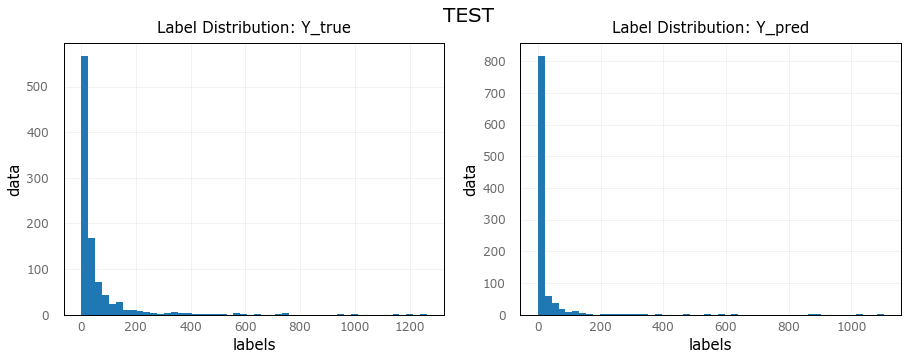

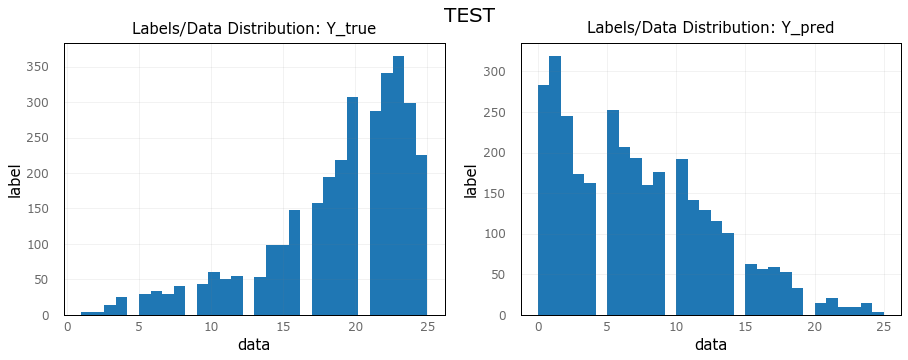

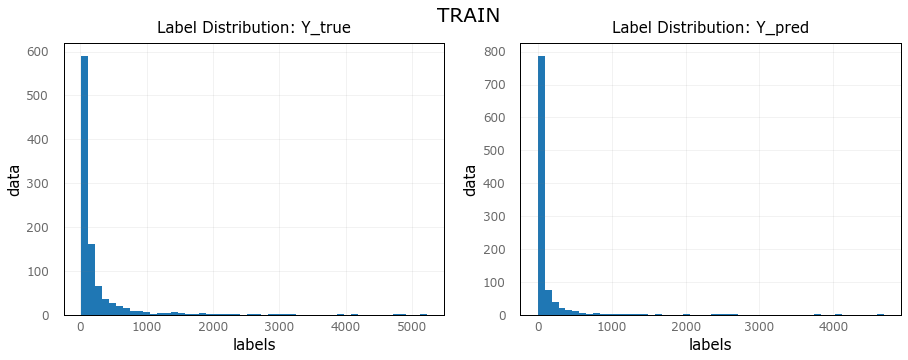

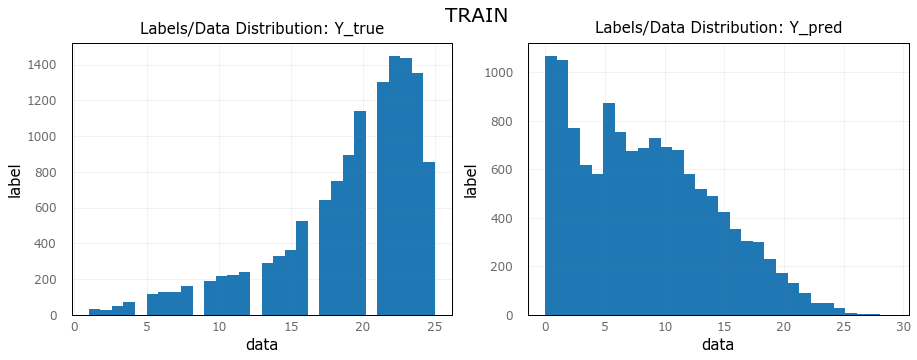

In [275]:
Y_pred_test, Y_pred_train, Y_test, Y_train = get_pred('delicious')
get_label_distribution('delicious',  Y_pred_test, Y_test, 'TEST')
get_labels_per_datum('delicious', Y_pred_test, Y_test, 'TEST')
                       
                       
get_label_distribution('delicious',  Y_pred_train, Y_train, 'TRAIN')
get_labels_per_datum('delicious', Y_pred_train, Y_train, 'TRAIN')

### RCV1-2K

RCV : # of train examples with no labels: 0.0
RCV : % of train examples with no labels: 0.0
RCV : # of test examples with no labels: 0.0
RCV : % of test examples with no labels: 0.0
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 184.79600977198697 
Predicted                 | 291.5647394136808 
True Std  data per label  | 1097.4142411198893 
Predicted                 | 1337.6568494146798
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 4.591394057526833 
Predicted                 | 2.9100614252189634 
True Std  labels per data | 5.6000546427966515 
Predicted                 | 3.2339017873952383
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 785.8151465798046 
Predicted                 | 1218.567996742671 
True Std  data per label  | 4375.2738199130845 
Predicted                 | 5333.484791220253
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

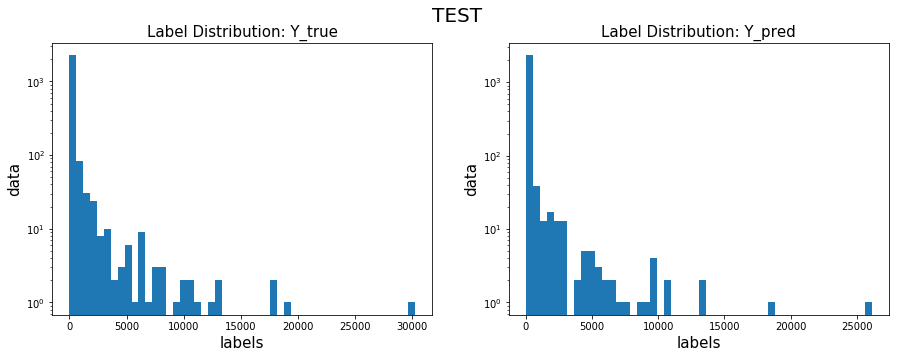

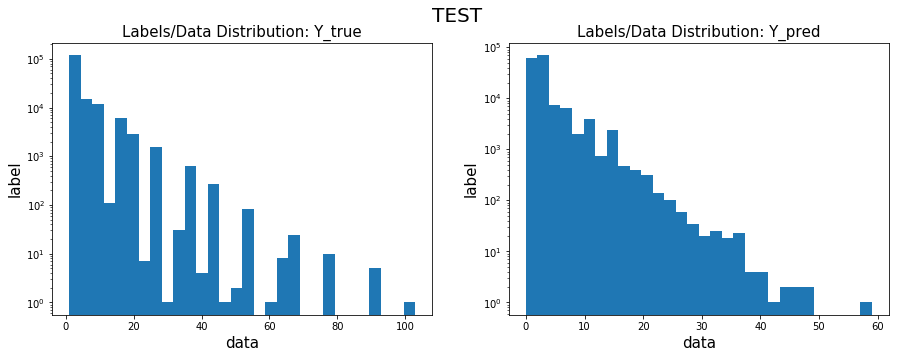

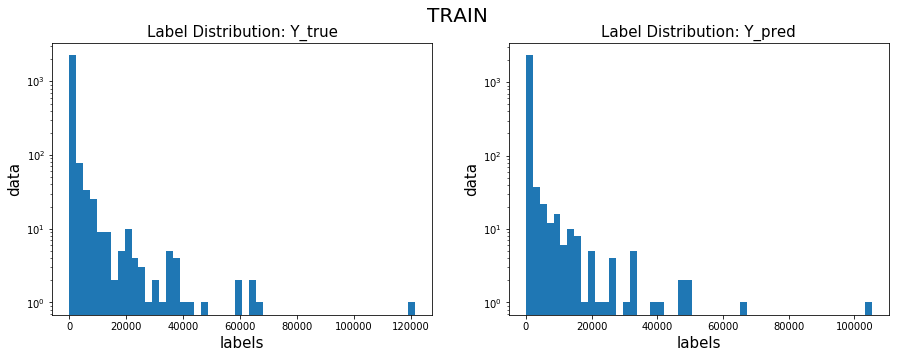

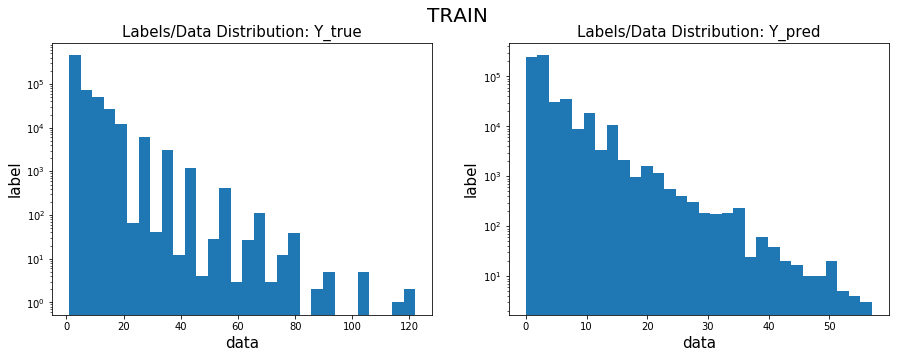

In [352]:
Y_pred_test, Y_pred_train, Y_test, Y_train = get_pred('RCV')
get_label_distribution('RCV',  Y_pred_test, Y_test, 'TEST')
get_labels_per_datum('dRCV', Y_pred_test, Y_test, 'TEST')
                       
                       
get_label_distribution('RCV',  Y_pred_train, Y_train, 'TRAIN')
get_labels_per_datum('RCV', Y_pred_train, Y_train, 'TRAIN')

### EURLex-4K

In [301]:
Y_pred_test, Y_pred_train, Y_test, Y_train = get_pred('eurlex')

eurlex : # of train examples with no labels: 28.0
eurlex : % of train examples with no labels: 0.007012271475081392
eurlex : # of test examples with no labels: 6.0
eurlex : % of test examples with no labels: 0.0015026296018031556
(3809, 3994) (3809, 3994)


~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 1.7804206309464197 
Predicted                 | 5.062093139709565 
True Std  data per label  | 6.8246223653018685 
Predicted                 | 13.538448382375337
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TEST ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 5.307954843791022 
Predicted                 | 1.8668941979522184 
True Std  labels per data | 1.364879299532659 
Predicted                 | 2.0622700025057124
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean data per label  | 9.074611917876815 
Predicted                 | 20.6707561342013 
True Std  data per label  | 29.879702748967706 
Predicted                 | 54.64337891609715
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~
True Mean labels per data | 5.313018855782225 
Predicted                 | 2.33245382585752 
True Std  labels per data | 1

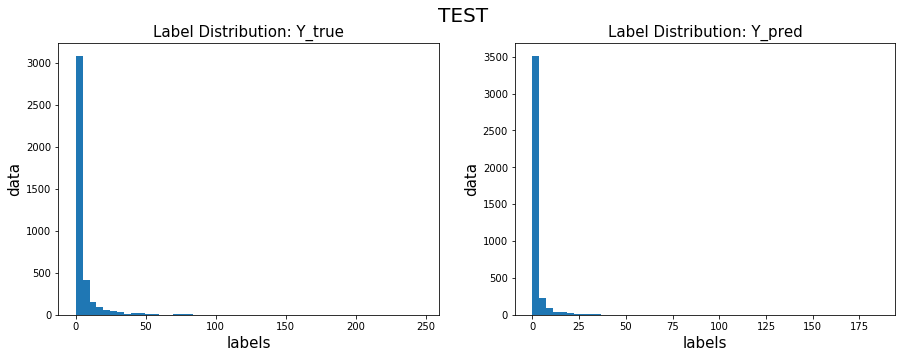

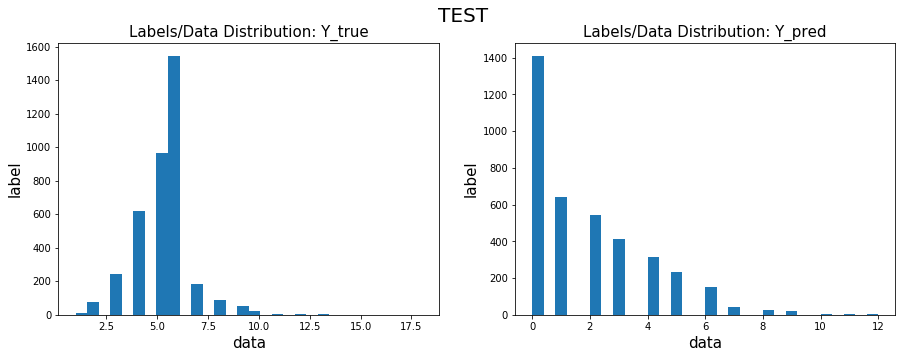

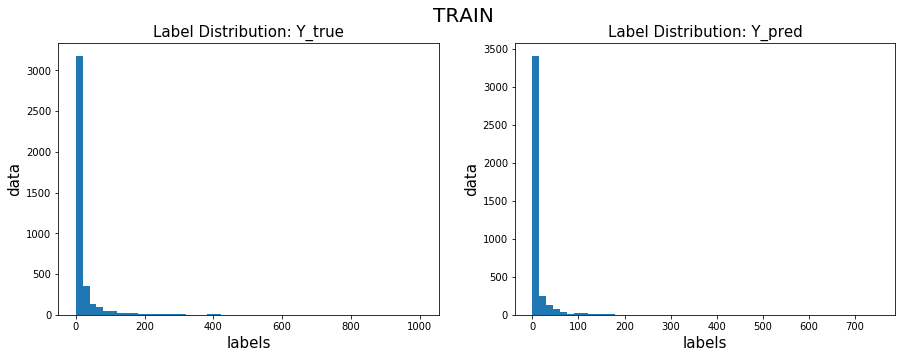

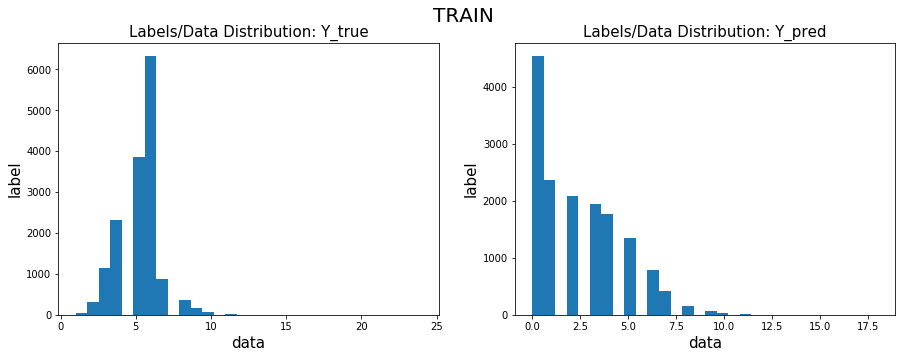

In [343]:
get_label_distribution('eurlex',  Y_pred_test, Y_test, 'TEST')
get_labels_per_datum('eurlex', Y_pred_test, Y_test, 'TEST')            
                       
get_label_distribution('eurlex',  Y_pred_train, Y_train, 'TRAIN')
get_labels_per_datum('eurlex', Y_pred_train, Y_train, 'TRAIN')

## Talos Bibtex

In [42]:
def get_talos_model(params, input_dim, output_dim):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(input_dim,)))
    model.add(Dense(params['layers'][0],
                    activation=params['activation'], 
                    kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    
    for i in range(1, len(params['layers'])):
        model.add(BatchNormalization())
        model.add(Dense(params['layers'][i], 
                        activation=params['activation'],
                        kernel_initializer=params['kernel_initializer']))
        model.add(Dropout(params['dropout']))        


    model.add(BatchNormalization())
    model.add(Dense(output_dim, 
                    activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))

    return model

In [43]:
def run_talos_model(TPU_worker=None):
    def _run_talos_model(x_train, y_train, x_test, y_test, params):
        import warnings
        # warnings.filterwarnings(action='once')
        warnings.filterwarnings('ignore')

        ks = [1, 3, 5]

        weights = get_inv_propensity(y_train, A=0.55, B=1.5).tolist()
        metrics_funcs = []

        for k in ks:
            metrics_funcs.extend([mapk(k, apk), mapk(k, soft_apk), mapk(k, strict_apk), mapk(k, strict_soft_apk), 
                                  mapk_propensity(k, weights),
                                  mean_nDCG_k(k, None), mean_nDCG_k(k, weights),
                                  mean_recall_k(k), 
                                  coverage_propensity(k, None), coverage_propensity(k, weights)])
        metrics_funcs.append(precision_acc)

        model = get_talos_model(params, x_train.shape[1], y_train.shape[1])

        #### TPU
        if TPU_worker:
            model = get_TPU_model(model, TPU_worker)
        ####

        model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', 
                      run_eagerly=True, 
                      metrics=metrics_funcs)

        callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001),
                    EarlyStopping(monitor='val_loss', verbose=1, patience=6)]

        history = model.fit(x_train, y_train,
                            validation_data=[x_test, y_test],
                            batch_size=params['batch_size'],
                            epochs=params['epochs'], 
                            callbacks=callbacks
                           ) 
        return history, model
    return _run_talos_model    

In [44]:
def search_with_talos(params, dataset_name, experiment_no="1", colab=False, TPU_worker=None):
    for i, split in enumerate(load_dataset(dataset_name, colab=colab)):
        X_train, Y_train, X_test, Y_test = split
        t = ta.Scan(x=X_train, y=Y_train, 
                    x_val=X_test, y_val=Y_test,
                    model=run_talos_model(TPU_worker),
                    params=params,
                    print_params=True,
                    experiment_name=dataset_name + "-" + str(experiment_no))
        break
    return t

In [32]:
def get_TPU_model(model, TPU_WORKER):
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
    return tpu_model

In [45]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if 'GPU' in x.device_type]

def get_available_tpu():
    # This address identifies the TPU we'll use when configuring TensorFlow.
    import os
    try:
        TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    except:
        return None
    return TPU_WORKER

def get_available_cpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if 'CPU' in x.device_type]

In [47]:
TPU_WORKER = get_available_tpu()
GPU_list = get_available_gpus()
device = None
if TPU_WORKER:
    print("TPU Worker:", TPU_WORKER)
elif len(GPU_list) > 0:
    device = GPU_list[0]
    print("Device:", device)
else:
    device = get_available_cpus()[0]
    print("Device:", device)

Device: /device:XLA_GPU:0


In [41]:
neurons = [800, 600, 300, 100]
layers = []
for i in range(1,4):
    layers.extend(list(combinations(neurons[:(i+2)], i)))

params = { 'layers': layers,

           'activation': ["relu", "tanh"],
           'optimizer': ['Adam'],

           'kernel_initializer': ['normal'],

           'epochs': [100],

           'dropout': [0.25, 0.5],

           'last_activation': ['sigmoid'],

           'batch_size': [128]

          }

In [ ]:
if TPU_WORKER:
    print('USING TPU')
    t = search_with_talos(params, 'bibtex', experiment_no="1", colab=False, TPU_worker=TPU_WORKER)
elif device:
    t = None
    with tf.device(device):
        print('USING', device)
        #t = search_with_talos(params, 'bibtex', experiment_no="1", colab=False)

In [236]:
t.data['Num of Layers'] = t.data['layers'].str.len()
t.data['Total neurons'] = t.data['layers'].apply(np.sum)

In [237]:
#t.data

,round_epochs,loss,map-[apk] @1,map-[soft_apk] @1,map-[strict_apk] @1,map-[strict_soft_apk] @1,map_prop@1,nDCG_prop@1,nDCG@1,recall@1,...,batch_size,dropout,epochs,kernel_initializer,last_activation,layers,optimizer,None,Num of Layers,Total neurons
0,20,0.017137,0.926883,0.926883,0.926883,0.926883,0.782312,0.926883,0.868091,0.544438,...,128,0.25,100,normal,sigmoid,"(800,)",Adam,0,1,800
1,24,0.018321,0.919271,0.919271,0.919271,0.919271,0.774598,0.919271,0.859523,0.539731,...,128,0.25,100,normal,sigmoid,"(600,)",Adam,1,1,600
2,31,0.021754,0.900240,0.900240,0.900240,0.900240,0.750310,0.900240,0.836200,0.523775,...,128,0.25,100,normal,sigmoid,"(300,)",Adam,2,1,300
3,26,0.019277,0.919271,0.919271,0.919271,0.919271,0.767152,0.919271,0.855072,0.536668,...,128,0.25,100,normal,sigmoid,"(800, 600)",Adam,3,2,1400
4,32,0.021685,0.910457,0.910457,0.910457,0.910457,0.757914,0.910457,0.844196,0.534073,...,128,0.25,100,normal,sigmoid,"(800, 300)",Adam,4,2,1100
5,48,0.029879,0.835537,0.835537,0.835537,0.835537,0.673967,0.835537,0.763228,0.475120,...,128,0.25,100,normal,sigmoid,"(800, 100)",Adam,5,2,900
6,32,0.022644,0.898037,0.898037,0.898037,0.898037,0.747726,0.898037,0.833128,0.524077,...,128,0.25,100,normal,sigmoid,"(600, 300)",Adam,6,2,900
7,51,0.030903,0.800280,0.800280,0.800280,0.800280,0.638915,0.800280,0.727354,0.448577,...,128,0.25,100,normal,sigmoid,"(600, 100)",Adam,7,2,700
8,54,0.029126,0.817708,0.817708,0.817708,0.817708,0.659254,0.817708,0.746962,0.469784,...,128,0.25,100,normal,sigmoid,"(300, 100)",Adam,8,2,400
9,57,0.031017,0.799479,0.799479,0.799479,0.799479,0.638625,0.799479,0.725541,0.446704,...,128,0.25,100,normal,sigmoid,"(800, 600, 300)",Adam,9,3,1700


In [243]:
r = ta.Reporting(t)

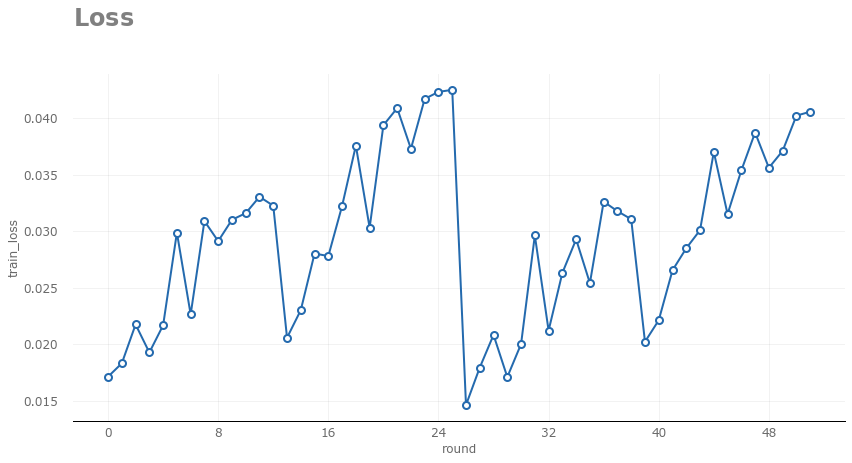

In [203]:
#ast.line(r.data, 'loss', title='Loss',  x_label='round', y_label='train_loss')

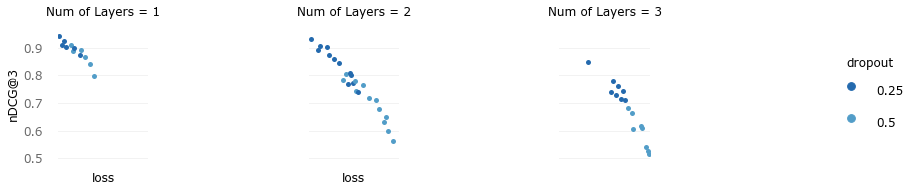

In [264]:
#Training 
#ast.grid(r.data, 'loss', 'nDCG@3', 'Num of Layers', 'dropout', col_wrap=3)

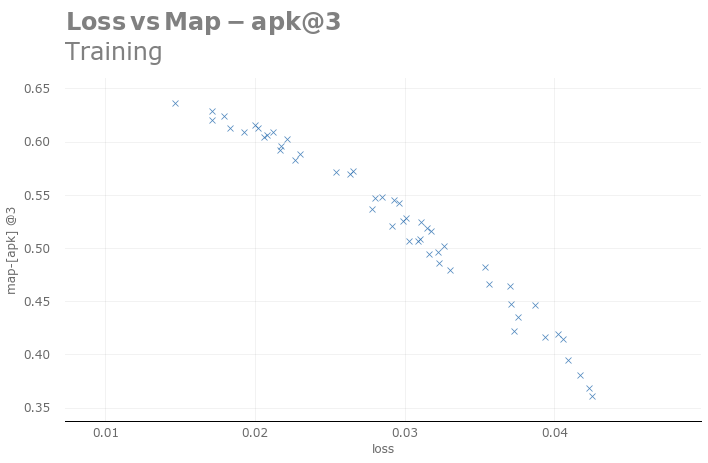

In [257]:
#ast.regs(r.data, 'loss', 'map-[apk] @3', title='Loss vs Map-apk@3', sub_title='Training', x_label='loss', y_label='map-[apk] @3')

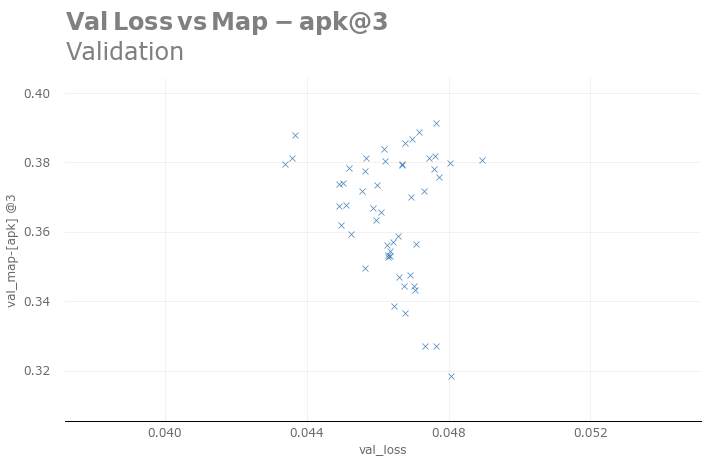

In [259]:
#ast.regs(r.data, 'val_loss', 'val_map-[apk] @3', title='Val Loss vs Map-apk@3',  sub_title='Validation', x_label='val_loss', y_label='val_map-[apk] @3')

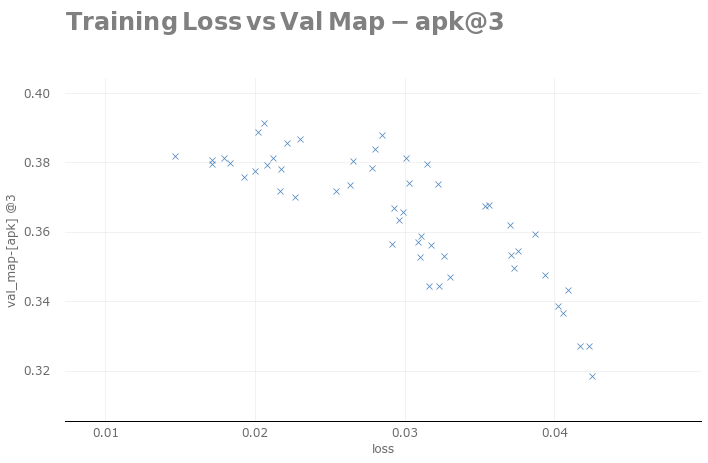

In [270]:
#ast.regs(r.data, 'loss', 'val_map-[apk] @3', title='Training Loss vs Val Map-apk@3',  x_label='loss', y_label='val_map-[apk] @3')

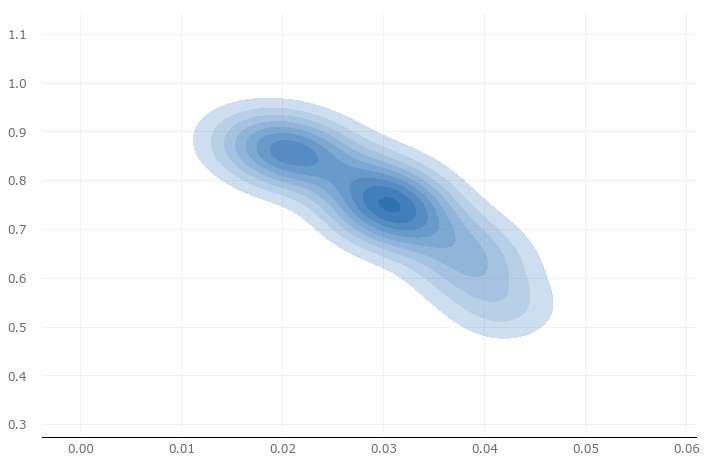

In [159]:
#r.plot_kde('loss', 'nDCG@1')

In [65]:
#r.correlate('val_loss')

map-[apk] @1                    0.082656
map-[soft_apk] @1               0.082656
map-[strict_apk] @1             0.082656
map-[strict_soft_apk] @1        0.082656
map_prop@1                      0.095632
nDCG_prop@1                     0.082656
nDCG@1                          0.089688
recall@1                        0.115724
coverage_prop@1                 0.082656
coverage@1                      0.095632
map-[apk] @3                    0.125150
map-[soft_apk] @3               0.103975
map-[strict_apk] @3             0.149146
map-[strict_soft_apk] @3        0.137949
map_prop@3                      0.128086
nDCG_prop@3                     0.109613
nDCG@3                          0.115636
recall@3                        0.104792
coverage_prop@3                 0.123092
coverage@3                      0.128086
map-[apk] @5                    0.109115
map-[soft_apk] @5               0.069998
map-[strict_apk] @5             0.154417
map-[strict_soft_apk] @5        0.134824
map_prop@5      

In [84]:
with open('saved_models.json', 'w') as outfile:
    json.dump(t.saved_models, outfile)
talos_weights = t.saved_weights

### Results

In [354]:
datasets = ['bibtex', 'delicious', 'mediamill', 'eurlex', 'RCV']

datasets_dict = defaultdict(lambda: defaultdict(int))
for d in datasets:
    histories_ = load_history(d)
    splits = len(histories_)
    for h in histories_:
        best_epoch = np.argmin(h['val_loss'])
        for metric, values in h.items():
            if metric == 'val_loss':
                datasets_dict[d][(metric, '-')] += values[best_epoch] / splits
            elif metric.startswith('val'):
                datasets_dict[d][(metric[4:-2], metric[-1])] += values[best_epoch] /splits

In [355]:
res_df = pd.DataFrame(datasets_dict)
res_df

bibtex  delicious  mediamill    eurlex       RCV
coverage               1  0.462709   0.356552   0.672024  0.259182  0.721900
                       3  0.481890   0.368071   0.701703  0.285410  0.731567
                       5  0.538100   0.373869   0.707497  0.297742  0.735029
coverage_prop          1  0.598725   0.691992   0.871211  0.590861  0.867119
                       3  0.542045   0.638761   0.802271  0.470478  0.837593
                       5  0.579024   0.593985   0.767020  0.409386  0.834765
map-[apk]              1  0.598725   0.691992   0.871211  0.590074  0.867266
                       3  0.357484   0.637446   0.718240  0.466562  0.689129
                       5  0.261957   0.590619   0.576928  0.379937  0.493820
map-[soft_apk]         1  0.598725   0.691992   0.871211  0.590074  0.867266
                       3  0.550939   0.638319   0.789146  0.468794  0.846061
                       5  0.603506   0.593323   0.772302  0.406885  0.863151
map-[strict_apk]       1  0.598725   0.691992   0.871211  0.590074  0.867266
                       3  0.324726   0.594151   0.696454  0.417907  0.675847
                       5  0.220853   0.524951   0.541061  0.318543  0.473174
map-[strict_soft_apk]  1  0.598725   0.691992   0.871211  0.590074  0.867266
                       3  0.495959   0.594982   0.756550  0.419978  0.826096
                       5  0.502941   0.527364   0.707084  0.340106  0.822279
map_prop               1  0.462709   0.356552   0.672024  0.259084  0.722036
                       3  0.481890   0.368071   0.701703  0.285455  0.731981
                       5  0.538100   0.373869   0.707497  0.297742  0.735395
nDCG                   1  0.535243   0.623932   0.847598  0.562688  0.843906
                       3  0.518586   0.563465   0.785691  0.435631  0.828785
                       5  0.543956   0.528184   0.757514  0.388157  0.834948
nDCG_prop              1  0.598725   0.691992   0.871211  0.590074  0.867266
                       3  0.549503   0.650938   0.804380  0.496587  0.846997
                       5  0.571342   0.616509   0.781792  0.446554  0.852882
recall                 1  0.324652   0.042279   0.245866  0.116290  0.386210
                       3  0.509811   0.113022   0.558437  0.269742  0.712316
                       5  0.596262   0.171167   0.708650  0.362599  0.778014
val_loss               -  0.047247   0.061376   0.075033  0.006537  0.005165

In [0]:
def loss_plot(dataset):
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 8
    plt.plot(histories[5]['loss'], label='train loss')
    plt.plot(histories[5]['val_loss'], label='val loss')
    plt.title(dataset + " :Train Loss vs Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()
    
    plt.plot(histories[5]['lr'])
    plt.title(dataset + " : Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("lr")
    plt.show()

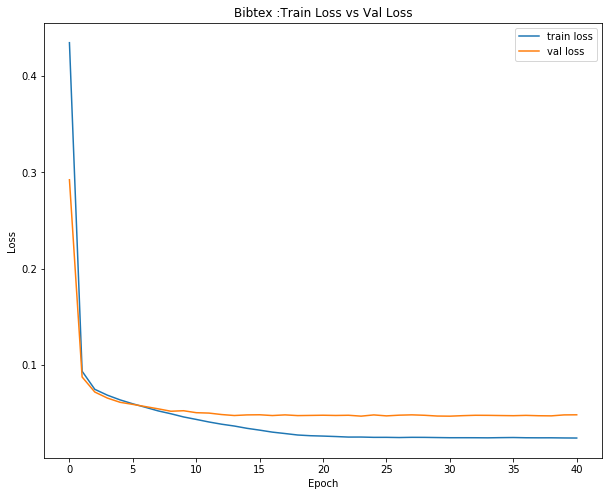

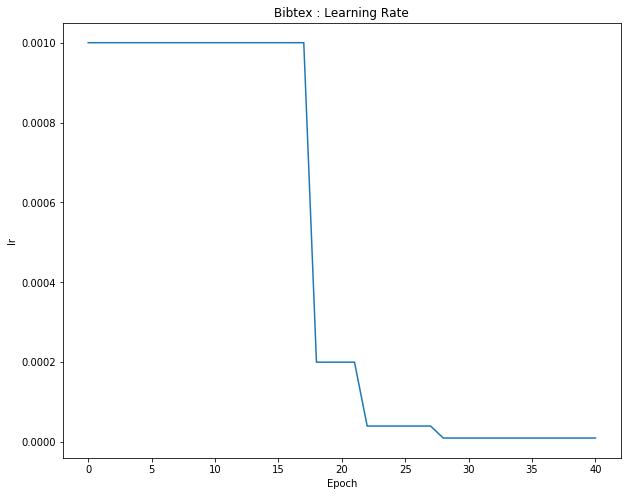

In [0]:
loss_plot('Bibtex')

In [0]:
def metrics_plot(dataset, history):
    ks = [1, 3, 5]
    c = 0
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30,37))
    for metric in history.keys():
        if metric.startswith('lr') or 'loss' in metric:
            continue
        if metric.startswith('val'):
            c = 1
        k = int(metric[-1])
        i = k//2 
        ax[i][c].plot(history[metric], label=metric)
        ax[i][c].set_title(dataset + ': k=' + str(k), fontsize=20)
        ax[i][c].set_xlabel("Epoch", fontsize=20)
        ax[i][c].set_ylabel("Percentage %", fontsize=20)
        ax[i][c].legend(loc='lower right', fontsize=15)
        c = 0

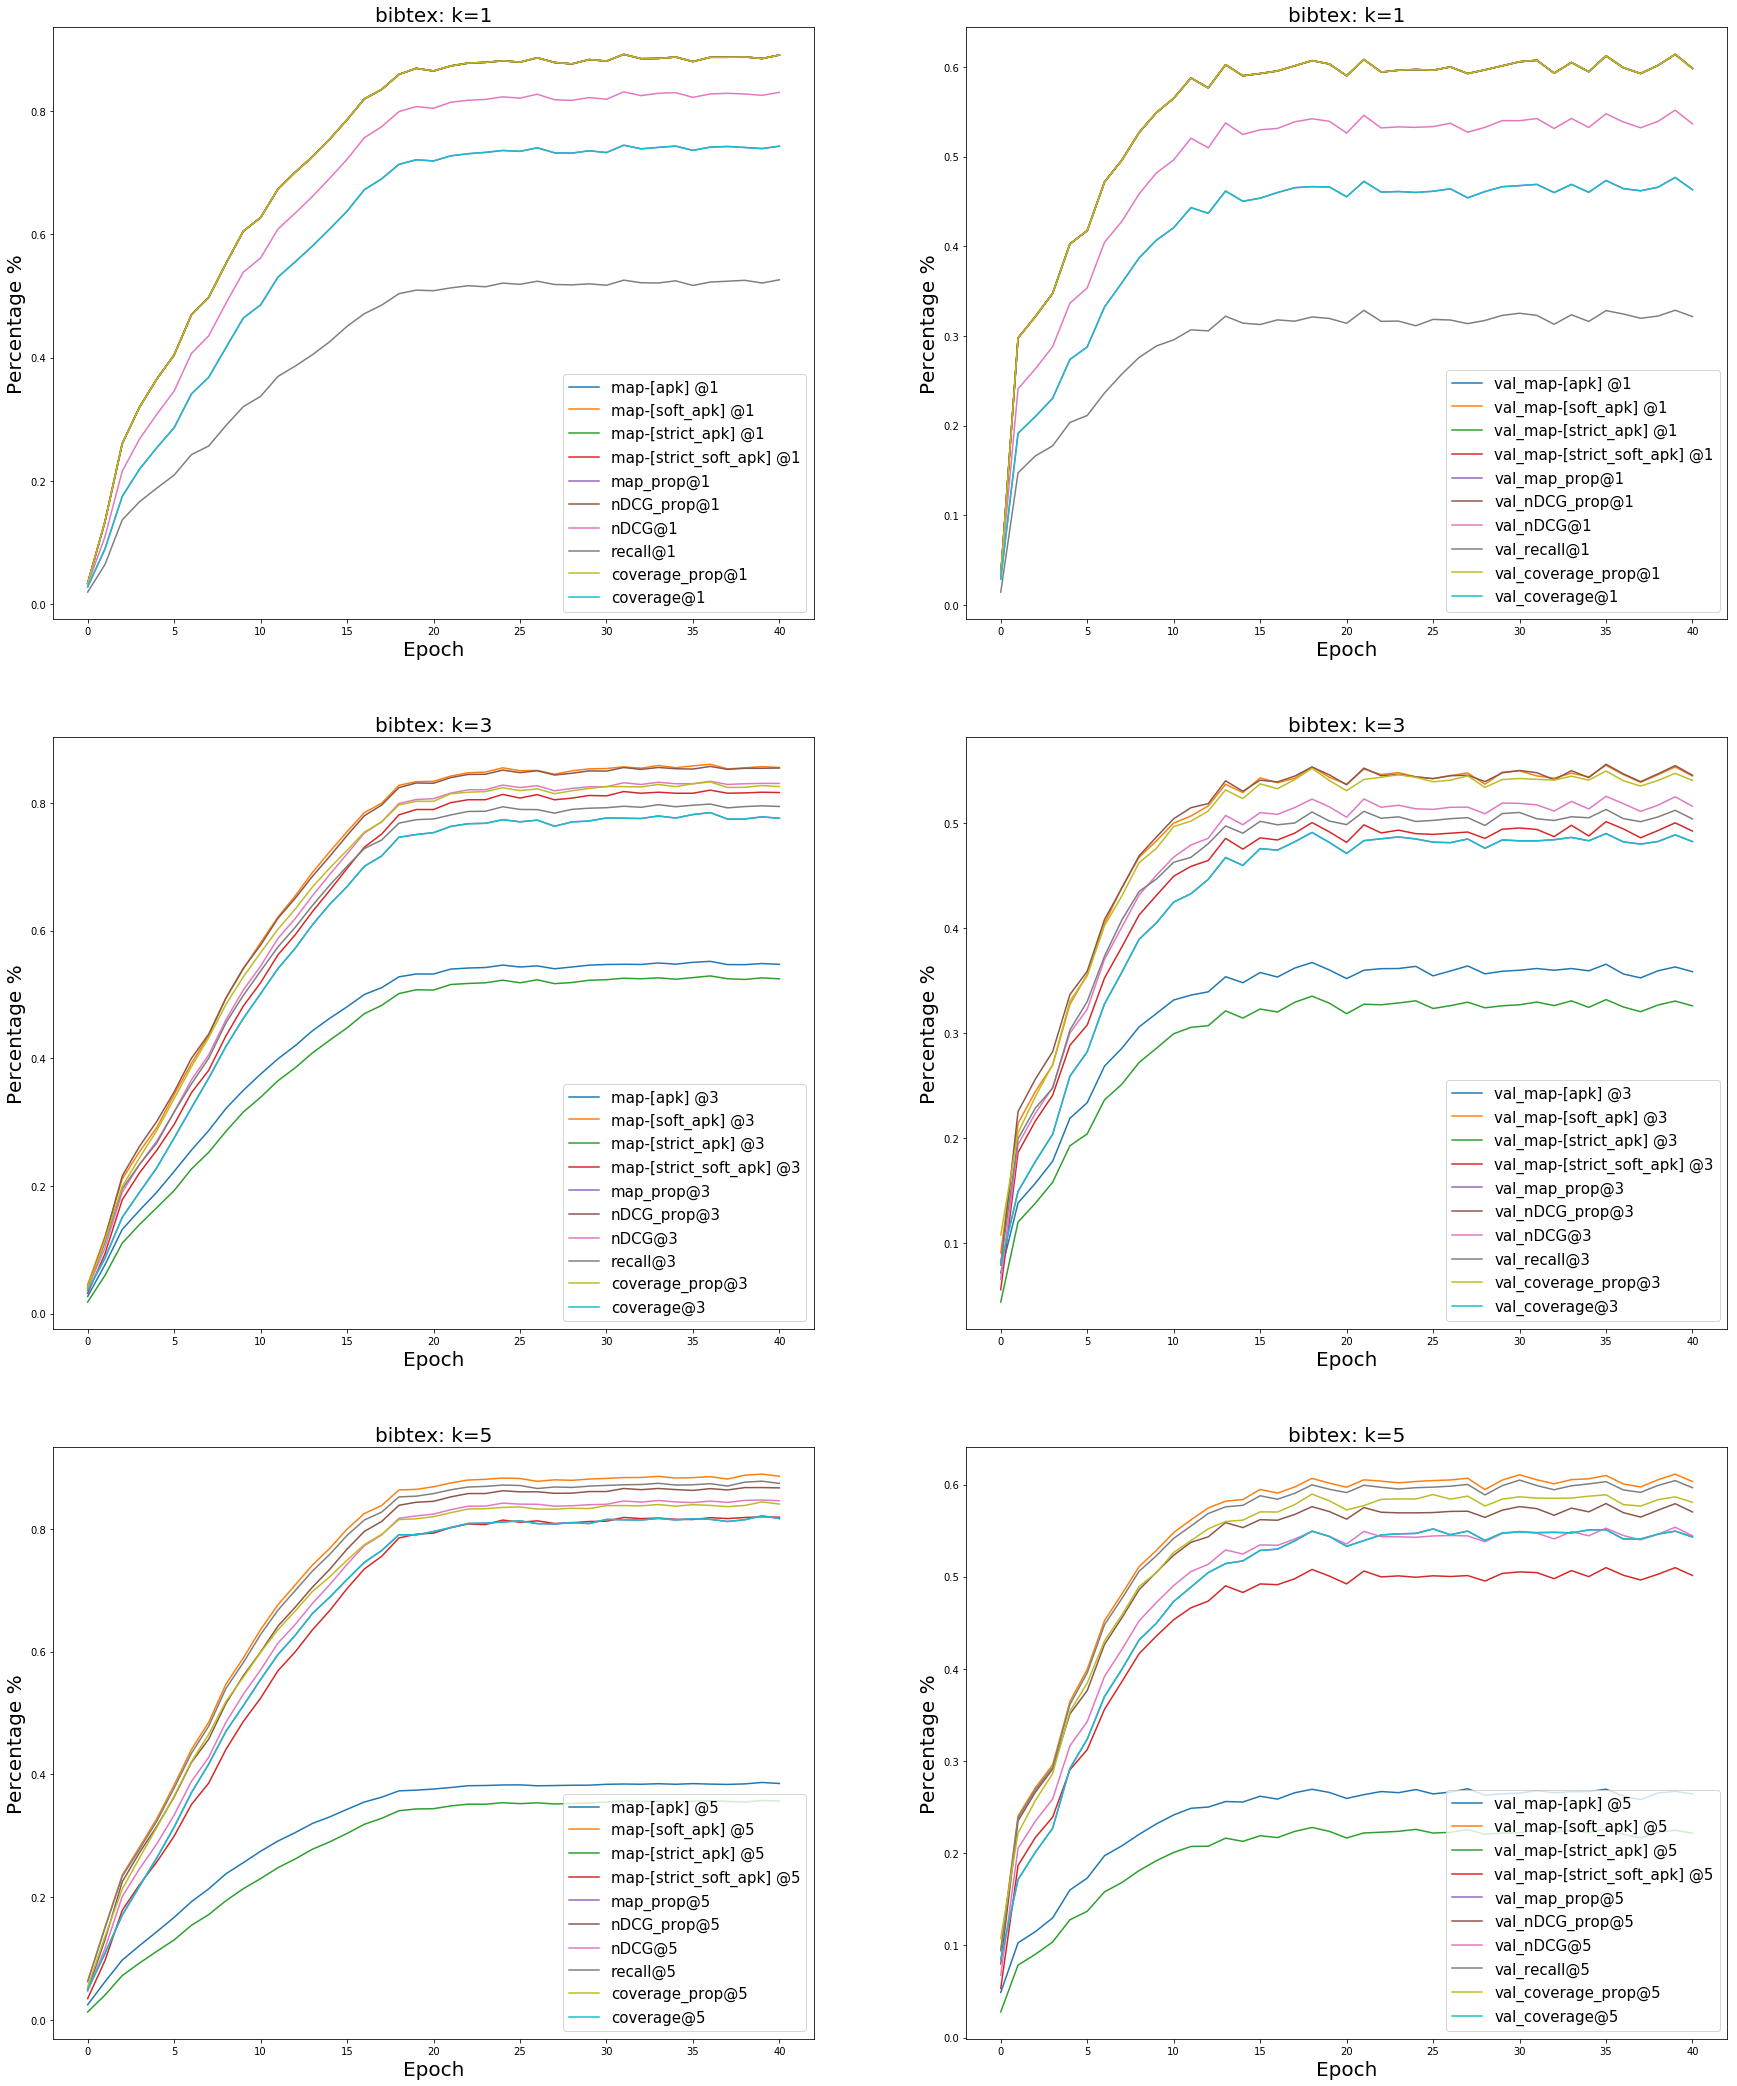

In [0]:
metrics_plot('bibtex', histories[5])

Links:
https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py